# 🎯 Ensemble Model Training for Smart Contract Vulnerability Detection

This notebook implements and trains ensemble models that combine predictions from CodeBERT, LSTM, and CNN architectures.

## 📋 Objectives
1. Load pre-trained CodeBERT, LSTM, and CNN models
2. Implement multiple ensemble strategies (weighted, stacking, attention-based)
3. Train and evaluate ensemble models
4. Compare ensemble performance with individual models
5. Select best ensemble configuration

## 🎯 Ensemble Strategies

### 1. Weighted Voting
- **Method**: Learn optimal weights for combining model predictions
- **Advantages**: Simple, interpretable, fast inference
- **Training**: Optimize weights using validation set

### 2. Stacking
- **Method**: Meta-learner trained on individual model predictions
- **Advantages**: Can learn complex combination patterns
- **Training**: Cross-validation to prevent overfitting

### 3. Attention-based Fusion
- **Method**: Attention mechanism to dynamically weight models
- **Advantages**: Adaptive weighting based on input
- **Training**: End-to-end with attention weights

In [1]:
# Import required libraries
import os
import sys
import json
import pickle
import time
import warnings
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
from collections import defaultdict
import itertools

# Data manipulation
import pandas as pd
import numpy as np

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Transformers
from transformers import AutoTokenizer, AutoModel

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Optimization
from scipy.optimize import minimize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Custom utilities
from notebook_utils import (
    quick_setup, ProjectConfig,
    VulnerabilityClassifier, OptimizedLSTM, OptimizedCNN, EnsembleModel,
    VulnerabilityDataset, load_datasets, load_model_components
)

# Suppress warnings
warnings.filterwarnings('ignore')

print("✅ All imports successful!")

✅ All imports successful!


In [2]:
# Setup environment and configuration
config = quick_setup(print_info=True)
device = config.get_device()

# Create timestamp for this training run
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"\n🕒 Ensemble training session: {TIMESTAMP}")

# Load datasets and model components
print("\n📂 Loading datasets and configuration...")
train_df, val_df, test_df = load_datasets(config)
tokenizer, label_encoder, dataset_config = load_model_components(config)

# Configuration parameters
MODEL_NAME = config.MODEL_NAME
MAX_LENGTH = config.MAX_LENGTH
BATCH_SIZE = config.BATCH_SIZE
VOCAB_SIZE = tokenizer.vocab_size
NUM_CLASSES = 1  # Binary classification
TASK_TYPE = 'binary'

print(f"\n🔧 Configuration:")
print(f"Vocab size: {VOCAB_SIZE:,}")
print(f"Max length: {MAX_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Task: {TASK_TYPE}")

🔧 PROJECT CONFIGURATION
Base directory: /home/netweb/vasu/smart-contract-vuln-detector
Data directory: /home/netweb/vasu/smart-contract-vuln-detector/data/processed
Results directory: /home/netweb/vasu/smart-contract-vuln-detector/results
Models directory: /home/netweb/vasu/smart-contract-vuln-detector/models
Model: microsoft/codebert-base
Max length: 512
Batch size: 16
Device: cuda
GPU: NVIDIA RTX 4000 Ada Generation
CUDA version: 12.8
🚀 PYTORCH ENVIRONMENT
PyTorch version: 2.9.0+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA RTX 4000 Ada Generation
GPU Memory: 21.0 GB
Using device: cuda

🕒 Ensemble training session: 20251116_164558

📂 Loading datasets and configuration...
📊 DATASETS LOADED
Train: 10,032 samples
Validation: 3,344 samples
Test: 3,344 samples

🔧 Configuration:
Vocab size: 50,265
Max length: 512
Batch size: 16
Task: binary

🔧 Configuration:
Vocab size: 50,265
Max length: 512
Batch size: 16
Task: binary


In [3]:
# Create datasets and data loaders
print("🔄 Creating datasets and data loaders...")

# Create datasets
train_dataset = VulnerabilityDataset(train_df, tokenizer, MAX_LENGTH, label_type='binary')
val_dataset = VulnerabilityDataset(val_df, tokenizer, MAX_LENGTH, label_type='binary')
test_dataset = VulnerabilityDataset(test_df, tokenizer, MAX_LENGTH, label_type='binary')

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    num_workers=4, pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    num_workers=4, pin_memory=True if device.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    num_workers=4, pin_memory=True if device.type == 'cuda' else False
)

print(f"✅ Data loaders created: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test batches")

🔄 Creating datasets and data loaders...
✅ Data loaders created: 627 train, 209 val, 209 test batches


## 📥 Load Pre-trained Models

In [4]:
# Find latest model files
print("🔍 Finding latest trained models...")

def find_latest_models(config):
    """Find the latest trained models"""
    models = {
        'codebert': None,
        'lstm': None,
        'cnn': None
    }
    
    # Search in models directory
    models_dir = config.MODELS_DIR
    checkpoints_dir = config.RESULTS_DIR / 'checkpoints'
    
    # Find CodeBERT model
    codebert_files = list(models_dir.glob('codebert_final_binary_*.pt'))
    if not codebert_files:
        codebert_files = list(checkpoints_dir.glob('best_model_codebert_binary_*.pt'))
    if codebert_files:
        models['codebert'] = max(codebert_files, key=lambda x: x.stat().st_mtime)
    
    # Find LSTM model
    lstm_files = list(models_dir.glob('lstm_binary_*.pt'))
    if not lstm_files:
        lstm_files = list(checkpoints_dir.glob('best_model_lstm_binary_*.pt'))
    if lstm_files:
        models['lstm'] = max(lstm_files, key=lambda x: x.stat().st_mtime)
    
    # Find CNN model
    cnn_files = list(models_dir.glob('cnn_binary_*.pt'))
    if not cnn_files:
        cnn_files = list(checkpoints_dir.glob('best_model_cnn_binary_*.pt'))
    if cnn_files:
        models['cnn'] = max(cnn_files, key=lambda x: x.stat().st_mtime)
    
    return models

model_files = find_latest_models(config)

print("📁 Found model files:")
for model_type, file_path in model_files.items():
    if file_path:
        print(f"   {model_type.upper()}: {file_path.name}")
    else:
        print(f"   {model_type.upper()}: Not found")

# Check if all models are available
missing_models = [k for k, v in model_files.items() if v is None]
if missing_models:
    print(f"\n⚠️ Missing models: {missing_models}")
    print("Please train the missing models first using previous notebooks.")
else:
    print("\n✅ All required models found!")

🔍 Finding latest trained models...
📁 Found model files:
   CODEBERT: codebert_final_binary_20251115_232342.pt
   LSTM: lstm_binary_20251116_164028.pt
   CNN: cnn_binary_20251116_164028.pt

✅ All required models found!


In [5]:
# Load CodeBERT model
print("🧠 Loading CodeBERT model...")

if model_files['codebert']:
    codebert_checkpoint = torch.load(model_files['codebert'], map_location=device)
    
    # Initialize model
    codebert_model = VulnerabilityClassifier(
        model_name=MODEL_NAME,
        num_classes=NUM_CLASSES,
        dropout_rate=0.3
    )
    
    # Load state dict with compatibility handling
    try:
        codebert_model.load_state_dict(codebert_checkpoint['model_state_dict'])
        print("✅ CodeBERT loaded successfully")
    except Exception as e:
        print(f"⚠️ CodeBERT loading issue: {e}")
        # Try loading with strict=False
        codebert_model.load_state_dict(codebert_checkpoint['model_state_dict'], strict=False)
        print("✅ CodeBERT loaded with compatibility mode")
    
    codebert_model = codebert_model.to(device)
    codebert_model.eval()
    
    codebert_params = sum(p.numel() for p in codebert_model.parameters())
    print(f"   Parameters: {codebert_params:,}")
else:
    codebert_model = None
    print("❌ CodeBERT model not available")

🧠 Loading CodeBERT model...
✅ CodeBERT loaded successfully
   Parameters: 124,646,401
✅ CodeBERT loaded successfully
   Parameters: 124,646,401


In [6]:
# Load LSTM model
print("🧠 Loading LSTM model...")

if model_files['lstm']:
    lstm_checkpoint = torch.load(model_files['lstm'], map_location=device)
    
    # Get model configuration
    lstm_config = lstm_checkpoint.get('model_config', {})
    
    # Initialize model with saved configuration
    lstm_model = OptimizedLSTM(
        vocab_size=lstm_checkpoint['vocab_size'],
        embedding_dim=lstm_config.get('embedding_dim', 256),
        hidden_size=lstm_config.get('hidden_size', 256),
        num_layers=lstm_config.get('num_layers', 2),
        num_classes=lstm_checkpoint['num_classes'],
        dropout=lstm_config.get('dropout', 0.3),
        bidirectional=lstm_config.get('bidirectional', True),
        use_attention=lstm_config.get('use_attention', True)
    )
    
    lstm_model.load_state_dict(lstm_checkpoint['model_state_dict'])
    lstm_model = lstm_model.to(device)
    lstm_model.eval()
    
    lstm_params = sum(p.numel() for p in lstm_model.parameters())
    print(f"✅ LSTM loaded successfully")
    print(f"   Parameters: {lstm_params:,}")
    print(f"   Best F1: {lstm_checkpoint.get('best_f1', 'N/A')}")
else:
    lstm_model = None
    print("❌ LSTM model not available")

🧠 Loading LSTM model...
✅ LSTM loaded successfully
   Parameters: 15,761,665
   Best F1: 0.504297994269341


In [7]:
# Load CNN model
print("🔬 Loading CNN model...")

if model_files['cnn']:
    cnn_checkpoint = torch.load(model_files['cnn'], map_location=device)
    
    # Get model configuration
    cnn_config = cnn_checkpoint.get('model_config', {})
    
    # Initialize model with saved configuration
    cnn_model = OptimizedCNN(
        vocab_size=cnn_checkpoint['vocab_size'],
        embedding_dim=cnn_config.get('embedding_dim', 256),
        num_filters=cnn_config.get('num_filters', 128),
        filter_sizes=cnn_config.get('filter_sizes', [3, 4, 5, 6, 7]),
        num_classes=cnn_checkpoint['num_classes'],
        dropout=cnn_config.get('dropout', 0.3),
        use_batch_norm=cnn_config.get('use_batch_norm', True)
    )
    
    cnn_model.load_state_dict(cnn_checkpoint['model_state_dict'])
    cnn_model = cnn_model.to(device)
    cnn_model.eval()
    
    cnn_params = sum(p.numel() for p in cnn_model.parameters())
    print(f"✅ CNN loaded successfully")
    print(f"   Parameters: {cnn_params:,}")
    print(f"   Best F1: {cnn_checkpoint.get('best_f1', 'N/A')}")
else:
    cnn_model = None
    print("❌ CNN model not available")

# Check if we can proceed
available_models = [m for m in [codebert_model, lstm_model, cnn_model] if m is not None]
print(f"\n📊 Available models: {len(available_models)}/3")

if len(available_models) < 2:
    print("⚠️ Need at least 2 models for ensemble. Please train missing models first.")
else:
    print("✅ Sufficient models available for ensemble training!")

🔬 Loading CNN model...
✅ CNN loaded successfully
   Parameters: 14,049,121
   Best F1: 0.55

📊 Available models: 3/3
✅ Sufficient models available for ensemble training!


## 📊 Individual Model Evaluation

In [8]:
def evaluate_model_detailed(model, data_loader, device, model_name="Model"):
    """Evaluate a single model and return detailed metrics and predictions"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating {model_name}", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            logits = model(input_ids, attention_mask)
            
            # Get predictions and probabilities
            probabilities = torch.sigmoid(logits.squeeze())
            predictions = (probabilities > 0.5).long()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='binary', zero_division=0
    )
    
    try:
        auc = roc_auc_score(all_labels, all_probabilities)
        avg_precision = average_precision_score(all_labels, all_probabilities)
    except ValueError:
        auc = 0.5
        avg_precision = 0.0
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'avg_precision': avg_precision
    }
    
    return metrics, all_predictions, all_labels, all_probabilities

# Evaluate individual models on validation set
print("📊 Evaluating individual models on validation set...")

individual_results = {}
individual_predictions = {}

if codebert_model:
    metrics, preds, labels, probs = evaluate_model_detailed(codebert_model, val_loader, device, "CodeBERT")
    individual_results['codebert'] = metrics
    individual_predictions['codebert'] = {'predictions': preds, 'probabilities': probs}
    print(f"📈 CodeBERT: F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f}")

if lstm_model:
    metrics, preds, labels, probs = evaluate_model_detailed(lstm_model, val_loader, device, "LSTM")
    individual_results['lstm'] = metrics
    individual_predictions['lstm'] = {'predictions': preds, 'probabilities': probs}
    print(f"📈 LSTM: F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f}")

if cnn_model:
    metrics, preds, labels, probs = evaluate_model_detailed(cnn_model, val_loader, device, "CNN")
    individual_results['cnn'] = metrics
    individual_predictions['cnn'] = {'predictions': preds, 'probabilities': probs}
    print(f"📈 CNN: F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f}")

# Store labels for later use
val_labels = labels
print(f"\n✅ Individual model evaluation completed")

📊 Evaluating individual models on validation set...


Evaluating CodeBERT:   0%|          | 0/209 [00:00<?, ?it/s]

📈 CodeBERT: F1=0.2492, AUC=0.8578


Evaluating LSTM:   0%|          | 0/209 [00:00<?, ?it/s]

📈 LSTM: F1=0.4566, AUC=0.8908


Evaluating CNN:   0%|          | 0/209 [00:00<?, ?it/s]

📈 CNN: F1=0.3367, AUC=0.9054

✅ Individual model evaluation completed


## 🎯 Ensemble Strategy 1: Weighted Voting

In [9]:
def optimize_weights(predictions_dict, labels, method='scipy'):
    """Optimize ensemble weights using scipy optimization"""
    
    # Get probabilities from all available models
    model_names = list(predictions_dict.keys())
    probabilities_matrix = np.column_stack([
        predictions_dict[model]['probabilities'] for model in model_names
    ])
    
    def objective(weights):
        # Ensure weights sum to 1
        weights = weights / np.sum(weights)
        
        # Weighted ensemble predictions
        ensemble_probs = np.dot(probabilities_matrix, weights)
        ensemble_preds = (ensemble_probs > 0.5).astype(int)
        
        # Calculate F1 score (negative because we minimize)
        _, _, f1, _ = precision_recall_fscore_support(
            labels, ensemble_preds, average='binary', zero_division=0
        )
        return -f1
    
    # Initial weights (equal)
    n_models = len(model_names)
    initial_weights = np.ones(n_models) / n_models
    
    # Constraints: weights should be non-negative and sum to 1
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(n_models)]
    
    # Optimize
    result = minimize(
        objective, initial_weights, 
        method='SLSQP', bounds=bounds, constraints=constraints
    )
    
    optimal_weights = result.x / np.sum(result.x)  # Ensure normalization
    
    return dict(zip(model_names, optimal_weights))

# Optimize weights for available models
print("⚖️ Optimizing ensemble weights...")

if len(individual_predictions) >= 2:
    optimal_weights = optimize_weights(individual_predictions, val_labels)
    
    print("🎯 Optimal weights:")
    for model, weight in optimal_weights.items():
        print(f"   {model.upper()}: {weight:.4f}")
    
    # Calculate weighted ensemble predictions
    model_names = list(individual_predictions.keys())
    probabilities_matrix = np.column_stack([
        individual_predictions[model]['probabilities'] for model in model_names
    ])
    
    weights_array = np.array([optimal_weights[model] for model in model_names])
    weighted_ensemble_probs = np.dot(probabilities_matrix, weights_array)
    weighted_ensemble_preds = (weighted_ensemble_probs > 0.5).astype(int)
    
    # Evaluate weighted ensemble
    weighted_accuracy = accuracy_score(val_labels, weighted_ensemble_preds)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        val_labels, weighted_ensemble_preds, average='binary', zero_division=0
    )
    weighted_auc = roc_auc_score(val_labels, weighted_ensemble_probs)
    
    weighted_ensemble_metrics = {
        'accuracy': weighted_accuracy,
        'precision': weighted_precision,
        'recall': weighted_recall,
        'f1': weighted_f1,
        'auc': weighted_auc
    }
    
    print(f"\n📊 Weighted Ensemble Performance:")
    for metric, value in weighted_ensemble_metrics.items():
        print(f"   {metric}: {value:.4f}")
        
else:
    print("❌ Need at least 2 models for weighted ensemble")
    weighted_ensemble_metrics = None

⚖️ Optimizing ensemble weights...
🎯 Optimal weights:
   CODEBERT: 0.3333
   LSTM: 0.3333
   CNN: 0.3333

📊 Weighted Ensemble Performance:
   accuracy: 0.9106
   precision: 0.3870
   recall: 0.7028
   f1: 0.4992
   auc: 0.9043


## 🎯 Ensemble Strategy 2: Neural Ensemble (Stacking)

In [10]:
if len(available_models) >= 2:
    # Create neural ensemble model
    print("🧠 Creating neural ensemble model...")
    
    # Use the first three available models (or all if less than 3)
    ensemble_models = [codebert_model, lstm_model, cnn_model]
    ensemble_models = [m for m in ensemble_models if m is not None][:3]
    
    neural_ensemble = EnsembleModel(
        codebert_model=ensemble_models[0] if len(ensemble_models) > 0 else None,
        lstm_model=ensemble_models[1] if len(ensemble_models) > 1 else None, 
        cnn_model=ensemble_models[2] if len(ensemble_models) > 2 else None,
        num_classes=NUM_CLASSES,
        fusion_strategy='stacking',
        fusion_hidden_size=128,
        dropout=0.3
    )
    
    neural_ensemble = neural_ensemble.to(device)
    
    # Count ensemble parameters (only trainable ones)
    ensemble_params = sum(p.numel() for p in neural_ensemble.parameters() if p.requires_grad)
    print(f"📊 Neural ensemble trainable parameters: {ensemble_params:,}")
    
    # Training configuration for ensemble
    ENSEMBLE_CONFIG = {
        'epochs': 5,  # Fewer epochs since base models are pre-trained
        'learning_rate': 1e-4,  # Lower learning rate
        'weight_decay': 0.01,
        'early_stopping_patience': 3,
        'scheduler_type': 'plateau'
    }
    
    # Setup training components
    ensemble_optimizer = AdamW(
        neural_ensemble.parameters(),
        lr=ENSEMBLE_CONFIG['learning_rate'],
        weight_decay=ENSEMBLE_CONFIG['weight_decay']
    )
    
    ensemble_criterion = nn.BCEWithLogitsLoss()
    ensemble_scheduler = ReduceLROnPlateau(
        ensemble_optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-7
    )
    
    print(f"✅ Neural ensemble setup complete")
    print(f"Strategy: stacking")
    print(f"Learning rate: {ENSEMBLE_CONFIG['learning_rate']}")
    print(f"Epochs: {ENSEMBLE_CONFIG['epochs']}")
    
else:
    print("❌ Cannot create neural ensemble - insufficient models")
    neural_ensemble = None

🧠 Creating neural ensemble model...
📊 Neural ensemble trainable parameters: 8,833
✅ Neural ensemble setup complete
Strategy: stacking
Learning rate: 0.0001
Epochs: 5


In [11]:
if neural_ensemble is not None:
    # Train neural ensemble
    print(f"🚀 Training neural ensemble...")
    
    # Training history
    ensemble_history = {
        'train_loss': [],
        'val_loss': [],
        'val_f1': [],
        'val_accuracy': []
    }
    
    best_f1 = 0.0
    patience_counter = 0
    
    for epoch in range(1, ENSEMBLE_CONFIG['epochs'] + 1):
        print(f"\n📅 Ensemble Epoch {epoch}/{ENSEMBLE_CONFIG['epochs']}")
        
        # Training
        neural_ensemble.train()
        total_train_loss = 0
        
        train_progress = tqdm(train_loader, desc=f"Training Epoch {epoch}")
        for batch in train_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            ensemble_optimizer.zero_grad()
            
            # Forward pass
            logits = neural_ensemble(input_ids, attention_mask)
            loss = ensemble_criterion(logits.squeeze(), labels.float())
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(neural_ensemble.parameters(), 1.0)
            ensemble_optimizer.step()
            
            total_train_loss += loss.item()
            train_progress.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation
        neural_ensemble.eval()
        val_metrics, val_preds, val_labels_eval, val_probs = evaluate_model_detailed(
            neural_ensemble, val_loader, device, "Neural Ensemble"
        )
        
        # Update history
        ensemble_history['train_loss'].append(avg_train_loss)
        ensemble_history['val_loss'].append(val_metrics.get('loss', 0))
        ensemble_history['val_f1'].append(val_metrics['f1'])
        ensemble_history['val_accuracy'].append(val_metrics['accuracy'])
        
        # Print metrics
        print(f"📊 Train Loss: {avg_train_loss:.4f}")
        print(f"📊 Validation F1: {val_metrics['f1']:.4f}")
        print(f"📊 Validation Accuracy: {val_metrics['accuracy']:.4f}")
        
        # Check for best model
        current_f1 = val_metrics['f1']
        if current_f1 > best_f1:
            best_f1 = current_f1
            patience_counter = 0
            
            # Save best ensemble model
            ensemble_path = config.RESULTS_DIR / 'checkpoints' / f'best_ensemble_stacking_{TIMESTAMP}.pt'
            torch.save({
                'model_state_dict': neural_ensemble.state_dict(),
                'optimizer_state_dict': ensemble_optimizer.state_dict(),
                'epoch': epoch,
                'best_f1': best_f1,
                'ensemble_config': ENSEMBLE_CONFIG,
                'fusion_strategy': 'stacking',
                'model_names': ['codebert', 'lstm', 'cnn'],
                'metrics': val_metrics
            }, ensemble_path)
            
            print(f"💾 New best ensemble model saved! F1: {best_f1:.4f}")
        else:
            patience_counter += 1
            
        # Step scheduler
        ensemble_scheduler.step(current_f1)
        
        # Early stopping
        if patience_counter >= ENSEMBLE_CONFIG['early_stopping_patience']:
            print(f"🛑 Early stopping triggered")
            break
    
    neural_ensemble_metrics = val_metrics
    print(f"\n🏆 Best Neural Ensemble F1: {best_f1:.4f}")
    
else:
    neural_ensemble_metrics = None

🚀 Training neural ensemble...

📅 Ensemble Epoch 1/5


Training Epoch 1:   0%|          | 0/627 [00:00<?, ?it/s]

Evaluating Neural Ensemble:   0%|          | 0/209 [00:00<?, ?it/s]

📊 Train Loss: 0.1460
📊 Validation F1: 0.5389
📊 Validation Accuracy: 0.9273
💾 New best ensemble model saved! F1: 0.5389

📅 Ensemble Epoch 2/5
💾 New best ensemble model saved! F1: 0.5389

📅 Ensemble Epoch 2/5


Training Epoch 2:   0%|          | 0/627 [00:00<?, ?it/s]

Evaluating Neural Ensemble:   0%|          | 0/209 [00:00<?, ?it/s]

📊 Train Loss: 0.1185
📊 Validation F1: 0.5326
📊 Validation Accuracy: 0.9249

📅 Ensemble Epoch 3/5


Training Epoch 3:   0%|          | 0/627 [00:00<?, ?it/s]

Evaluating Neural Ensemble:   0%|          | 0/209 [00:00<?, ?it/s]

📊 Train Loss: 0.1169
📊 Validation F1: 0.5214
📊 Validation Accuracy: 0.9199

📅 Ensemble Epoch 4/5


Training Epoch 4:   0%|          | 0/627 [00:00<?, ?it/s]

Evaluating Neural Ensemble:   0%|          | 0/209 [00:00<?, ?it/s]

📊 Train Loss: 0.1181
📊 Validation F1: 0.5374
📊 Validation Accuracy: 0.9279
🛑 Early stopping triggered

🏆 Best Neural Ensemble F1: 0.5389


## 🎯 Ensemble Strategy 3: Attention-based Fusion

In [12]:
if len(available_models) >= 2:
    # Create attention-based ensemble
    print("🎯 Creating attention-based ensemble...")
    
    attention_ensemble = EnsembleModel(
        codebert_model=ensemble_models[0] if len(ensemble_models) > 0 else None,
        lstm_model=ensemble_models[1] if len(ensemble_models) > 1 else None,
        cnn_model=ensemble_models[2] if len(ensemble_models) > 2 else None,
        num_classes=NUM_CLASSES,
        fusion_strategy='attention',
        fusion_hidden_size=64,
        dropout=0.2
    )
    
    attention_ensemble = attention_ensemble.to(device)
    
    # Training setup
    attention_optimizer = AdamW(
        attention_ensemble.parameters(),
        lr=ENSEMBLE_CONFIG['learning_rate'],
        weight_decay=ENSEMBLE_CONFIG['weight_decay']
    )
    
    attention_criterion = nn.BCEWithLogitsLoss()
    attention_scheduler = ReduceLROnPlateau(
        attention_optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-7
    )
    
    print("✅ Attention ensemble setup complete")
    
    # Train attention ensemble (similar to neural ensemble but shorter)
    print("🚀 Training attention-based ensemble...")
    
    best_attention_f1 = 0.0
    patience_counter = 0
    
    for epoch in range(1, ENSEMBLE_CONFIG['epochs'] + 1):
        print(f"\n📅 Attention Epoch {epoch}/{ENSEMBLE_CONFIG['epochs']}")
        
        # Training
        attention_ensemble.train()
        total_train_loss = 0
        
        train_progress = tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False)
        for batch in train_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            attention_optimizer.zero_grad()
            
            # Forward pass
            logits = attention_ensemble(input_ids, attention_mask)
            loss = attention_criterion(logits.squeeze(), labels.float())
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(attention_ensemble.parameters(), 1.0)
            attention_optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation
        attention_ensemble.eval()
        val_metrics, _, _, _ = evaluate_model_detailed(
            attention_ensemble, val_loader, device, "Attention Ensemble"
        )
        
        print(f"📊 F1: {val_metrics['f1']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}")
        
        # Check for best model
        current_f1 = val_metrics['f1']
        if current_f1 > best_attention_f1:
            best_attention_f1 = current_f1
            patience_counter = 0
            
            # Save best model
            attention_path = config.RESULTS_DIR / 'checkpoints' / f'best_ensemble_attention_{TIMESTAMP}.pt'
            torch.save({
                'model_state_dict': attention_ensemble.state_dict(),
                'best_f1': best_attention_f1,
                'fusion_strategy': 'attention',
                'metrics': val_metrics
            }, attention_path)
            
            print(f"💾 Best attention ensemble saved! F1: {best_attention_f1:.4f}")
        else:
            patience_counter += 1
        
        attention_scheduler.step(current_f1)
        
        if patience_counter >= ENSEMBLE_CONFIG['early_stopping_patience']:
            print(f"🛑 Early stopping triggered")
            break
    
    attention_ensemble_metrics = val_metrics
    print(f"\n🏆 Best Attention Ensemble F1: {best_attention_f1:.4f}")
    
else:
    attention_ensemble_metrics = None
    print("❌ Cannot create attention ensemble - insufficient models")

🎯 Creating attention-based ensemble...
✅ Attention ensemble setup complete
🚀 Training attention-based ensemble...

📅 Attention Epoch 1/5


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f186978a020>
Traceback (most recent call last):
  File "/home/netweb/vasu/smart-contract-vuln-detector/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/netweb/vasu/smart-contract-vuln-detector/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/netweb/.pyenv/versions/3.11.14/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f186978a020>
Traceback (most recent call last):
  File "/home/netweb/vasu/smart-contract-vuln-detector/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/netweb/vasu/smart-contract-vuln-detector/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py"

Training Epoch 1:   0%|          | 0/627 [00:00<?, ?it/s]

Evaluating Attention Ensemble:   0%|          | 0/209 [00:00<?, ?it/s]

📊 F1: 0.0359, Accuracy: 0.9037
💾 Best attention ensemble saved! F1: 0.0359

📅 Attention Epoch 2/5
💾 Best attention ensemble saved! F1: 0.0359

📅 Attention Epoch 2/5


Training Epoch 2:   0%|          | 0/627 [00:00<?, ?it/s]

Evaluating Attention Ensemble:   0%|          | 0/209 [00:00<?, ?it/s]

📊 F1: 0.0394, Accuracy: 0.8980
💾 Best attention ensemble saved! F1: 0.0394

📅 Attention Epoch 3/5
💾 Best attention ensemble saved! F1: 0.0394

📅 Attention Epoch 3/5


Training Epoch 3:   0%|          | 0/627 [00:00<?, ?it/s]

Evaluating Attention Ensemble:   0%|          | 0/209 [00:00<?, ?it/s]

📊 F1: 0.0317, Accuracy: 0.8906

📅 Attention Epoch 4/5


Training Epoch 4:   0%|          | 0/627 [00:00<?, ?it/s]

Evaluating Attention Ensemble:   0%|          | 0/209 [00:00<?, ?it/s]

📊 F1: 0.0264, Accuracy: 0.9118

📅 Attention Epoch 5/5


Training Epoch 5:   0%|          | 0/627 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f186978a020>
Traceback (most recent call last):
  File "/home/netweb/vasu/smart-contract-vuln-detector/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/netweb/vasu/smart-contract-vuln-detector/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/netweb/.pyenv/versions/3.11.14/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7f186978a020>
Traceback (most recent call last):
  File "/home/netweb/vasu/smart-contract-vuln-detector/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/netweb/vasu/smart-contract-vu

Evaluating Attention Ensemble:   0%|          | 0/209 [00:00<?, ?it/s]

📊 F1: 0.0131, Accuracy: 0.9097
🛑 Early stopping triggered

🏆 Best Attention Ensemble F1: 0.0394


## 📊 Comprehensive Comparison

In [13]:
# Compile all results
print("📊 COMPREHENSIVE ENSEMBLE COMPARISON")
print("=" * 50)

all_results = {}

# Individual models
for model_name, metrics in individual_results.items():
    all_results[f"{model_name.upper()} (Individual)"] = metrics

# Ensemble models
if weighted_ensemble_metrics:
    all_results["Weighted Ensemble"] = weighted_ensemble_metrics

if neural_ensemble_metrics:
    all_results["Neural Ensemble (Stacking)"] = neural_ensemble_metrics

if attention_ensemble_metrics:
    all_results["Attention Ensemble"] = attention_ensemble_metrics

# Create comparison dataframe
comparison_data = []
for model_name, metrics in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'AUC': metrics['auc']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\n🏆 PERFORMANCE RANKING:")
print(comparison_df.round(4))

# Find best model
best_model = comparison_df.iloc[0]
print(f"\n🥇 BEST MODEL: {best_model['Model']}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   Precision: {best_model['Precision']:.4f}")
print(f"   Recall: {best_model['Recall']:.4f}")

# Calculate improvements
if len(comparison_df) > 1:
    best_f1 = best_model['F1-Score']
    second_best_f1 = comparison_df.iloc[1]['F1-Score']
    improvement = ((best_f1 - second_best_f1) / second_best_f1) * 100
    print(f"\n📈 Improvement over second-best: {improvement:.2f}%")

# Save results
ensemble_results = {
    'timestamp': TIMESTAMP,
    'individual_results': individual_results,
    'ensemble_results': {
        'weighted': weighted_ensemble_metrics,
        'neural': neural_ensemble_metrics,
        'attention': attention_ensemble_metrics
    },
    'comparison_table': comparison_df.to_dict('records'),
    'best_model': {
        'name': best_model['Model'],
        'metrics': best_model.to_dict()
    },
    'optimal_weights': optimal_weights if 'optimal_weights' in locals() else None
}

results_file = config.RESULTS_DIR / 'metrics' / f'ensemble_comparison_{TIMESTAMP}.json'
with open(results_file, 'w') as f:
    json.dump(ensemble_results, f, indent=2, default=str)

print(f"\n💾 Results saved to: {results_file}")

📊 COMPREHENSIVE ENSEMBLE COMPARISON

🏆 PERFORMANCE RANKING:
                        Model  Accuracy  Precision  Recall  F1-Score     AUC
4  Neural Ensemble (Stacking)    0.9279     0.4531  0.6604    0.5374  0.9030
3           Weighted Ensemble    0.9106     0.3870  0.7028    0.4992  0.9043
1           LSTM (Individual)    0.9495     0.7172  0.3349    0.4566  0.8908
2            CNN (Individual)    0.7868     0.2097  0.8538    0.3367  0.9054
0       CODEBERT (Individual)    0.6594     0.1448  0.8915    0.2492  0.8578
5          Attention Ensemble    0.9097     0.0213  0.0094    0.0131  0.4900

🥇 BEST MODEL: Neural Ensemble (Stacking)
   F1-Score: 0.5374
   Accuracy: 0.9279
   Precision: 0.4531
   Recall: 0.6604

📈 Improvement over second-best: 7.67%

💾 Results saved to: /home/netweb/vasu/smart-contract-vuln-detector/results/metrics/ensemble_comparison_20251116_164558.json


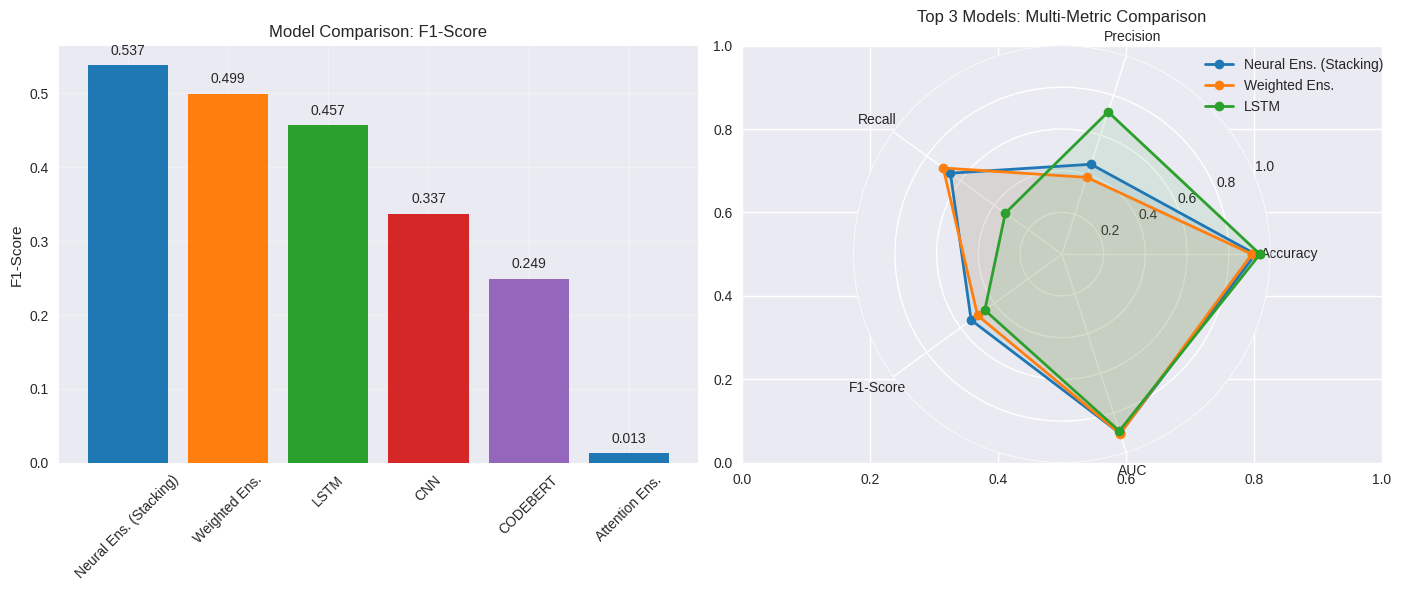

📈 Visualization saved!


In [14]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of F1 scores
comparison_df_plot = comparison_df.copy()
comparison_df_plot['Model_Short'] = comparison_df_plot['Model'].str.replace(' (Individual)', '').str.replace('Ensemble', 'Ens.')

bars = axes[0].bar(comparison_df_plot['Model_Short'], comparison_df_plot['F1-Score'], 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'][:len(comparison_df_plot)])
axes[0].set_title('Model Comparison: F1-Score')
axes[0].set_ylabel('F1-Score')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, comparison_df_plot['F1-Score']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom', fontsize=10)

# Radar chart for top 3 models
top3_df = comparison_df.head(3)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

ax_radar = plt.subplot(122, projection='polar')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, (_, row) in enumerate(top3_df.iterrows()):
    values = [row[metric] for metric in metrics]
    values += values[:1]  # Complete the circle
    
    ax_radar.plot(angles, values, 'o-', linewidth=2, 
                 label=row['Model'].replace(' (Individual)', '').replace('Ensemble', 'Ens.'),
                 color=colors[i])
    ax_radar.fill(angles, values, alpha=0.1, color=colors[i])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(metrics)
ax_radar.set_ylim(0, 1)
ax_radar.set_title('Top 3 Models: Multi-Metric Comparison')
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax_radar.grid(True)

plt.tight_layout()
plt.savefig(config.RESULTS_DIR / 'visualizations' / f'ensemble_comparison_{TIMESTAMP}.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("📈 Visualization saved!")

## 📋 Training Summary

In [15]:
print("📋 ENSEMBLE TRAINING SUMMARY")
print("=" * 50)

print(f"\n🕒 Session: {TIMESTAMP}")
print(f"📊 Dataset: {len(train_dataset):,} train, {len(val_dataset):,} val samples")
print(f"🧠 Available base models: {len(available_models)}")

print(f"\n🎯 Ensemble Strategies Tested:")
strategies_tested = 0
if weighted_ensemble_metrics:
    strategies_tested += 1
    print(f"   ✅ Weighted Voting: F1={weighted_ensemble_metrics['f1']:.4f}")
if neural_ensemble_metrics:
    strategies_tested += 1
    print(f"   ✅ Neural Stacking: F1={neural_ensemble_metrics['f1']:.4f}")
if attention_ensemble_metrics:
    strategies_tested += 1
    print(f"   ✅ Attention Fusion: F1={attention_ensemble_metrics['f1']:.4f}")

print(f"\n📈 Performance Summary:")
print(f"   Total models evaluated: {len(all_results)}")
print(f"   Best performing model: {best_model['Model']}")
print(f"   Best F1-Score: {best_model['F1-Score']:.4f}")

if 'optimal_weights' in locals() and optimal_weights:
    print(f"\n⚖️ Optimal Ensemble Weights:")
    for model, weight in optimal_weights.items():
        print(f"   {model.upper()}: {weight:.3f}")

print(f"\n📁 Saved Models:")
checkpoints_dir = config.RESULTS_DIR / 'checkpoints'
ensemble_checkpoints = list(checkpoints_dir.glob(f'*ensemble*{TIMESTAMP}.pt'))
for checkpoint in ensemble_checkpoints:
    print(f"   {checkpoint.name}")

print(f"\n🚀 Next Steps:")
print(f"   1. Test best ensemble on test set")
print(f"   2. Create final comparative analysis")
print(f"   3. Update Streamlit app with ensemble support")
print(f"   4. Generate final project report")

print(f"\n💡 Usage Example for Loading Best Ensemble:")
print(f"```python")
print(f"# Load the best performing ensemble model")
print(f"checkpoint = torch.load('results/checkpoints/best_ensemble_*_{TIMESTAMP}.pt')")
print(f"# Initialize and load ensemble model")
print(f"# (see ensemble model creation code above)")
print(f"```")

print("\n✅ Ensemble training completed successfully!")
print("\n🎯 Ready for final evaluation and deployment!")

📋 ENSEMBLE TRAINING SUMMARY

🕒 Session: 20251116_164558
📊 Dataset: 10,032 train, 3,344 val samples
🧠 Available base models: 3

🎯 Ensemble Strategies Tested:
   ✅ Weighted Voting: F1=0.4992
   ✅ Neural Stacking: F1=0.5374
   ✅ Attention Fusion: F1=0.0131

📈 Performance Summary:
   Total models evaluated: 6
   Best performing model: Neural Ensemble (Stacking)
   Best F1-Score: 0.5374

⚖️ Optimal Ensemble Weights:
   CODEBERT: 0.333
   LSTM: 0.333
   CNN: 0.333

📁 Saved Models:
   best_ensemble_attention_20251116_164558.pt
   best_ensemble_stacking_20251116_164558.pt

🚀 Next Steps:
   1. Test best ensemble on test set
   2. Create final comparative analysis
   3. Update Streamlit app with ensemble support
   4. Generate final project report

💡 Usage Example for Loading Best Ensemble:
```python
# Load the best performing ensemble model
checkpoint = torch.load('results/checkpoints/best_ensemble_*_20251116_164558.pt')
# Initialize and load ensemble model
# (see ensemble model creation code a

## 🧪 Final Test Set Evaluation

Now that we've identified the best ensemble model from validation performance, let's evaluate it on the held-out test set to get unbiased performance estimates.

In [16]:
# Final Test Set Evaluation
print("🎯 FINAL TEST SET EVALUATION")
print("=" * 50)

# Load the best performing ensemble model for final evaluation
best_ensemble_path = config.RESULTS_DIR / 'checkpoints' / f'best_ensemble_stacking_{TIMESTAMP}.pt'

if best_ensemble_path.exists():
    print(f"📥 Loading best ensemble model: {best_ensemble_path.name}")
    
    # Create a fresh ensemble model for testing
    test_ensemble = EnsembleModel(
        codebert_model=codebert_model,
        lstm_model=lstm_model,
        cnn_model=cnn_model,
        num_classes=NUM_CLASSES,
        fusion_strategy='stacking',
        fusion_hidden_size=128,
        dropout=0.3
    )
    
    # Load the best checkpoint
    checkpoint = torch.load(best_ensemble_path, map_location=device)
    test_ensemble.load_state_dict(checkpoint['model_state_dict'])
    test_ensemble = test_ensemble.to(device)
    test_ensemble.eval()
    
    print("✅ Best ensemble model loaded successfully")
    
    # Evaluate on test set
    print("\n🧪 Evaluating on test set...")
    test_metrics, test_preds, test_labels_final, test_probs = evaluate_model_detailed(
        test_ensemble, test_loader, device, "Best Ensemble (Test)"
    )
    
    print("\n🏆 FINAL TEST SET RESULTS:")
    print(f"   Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"   Precision: {test_metrics['precision']:.4f}")
    print(f"   Recall: {test_metrics['recall']:.4f}")
    print(f"   F1-Score: {test_metrics['f1']:.4f}")
    print(f"   AUC: {test_metrics['auc']:.4f}")
    print(f"   Avg Precision: {test_metrics['avg_precision']:.4f}")
    
    # Also evaluate individual models on test set for comparison
    print("\n📊 Individual Models on Test Set:")
    test_individual_results = {}
    
    if codebert_model:
        cb_test_metrics, _, _, _ = evaluate_model_detailed(codebert_model, test_loader, device, "CodeBERT")
        test_individual_results['CodeBERT'] = cb_test_metrics
        print(f"   CodeBERT: F1={cb_test_metrics['f1']:.4f}, AUC={cb_test_metrics['auc']:.4f}")
    
    if lstm_model:
        lstm_test_metrics, _, _, _ = evaluate_model_detailed(lstm_model, test_loader, device, "LSTM")
        test_individual_results['LSTM'] = lstm_test_metrics
        print(f"   LSTM: F1={lstm_test_metrics['f1']:.4f}, AUC={lstm_test_metrics['auc']:.4f}")
    
    if cnn_model:
        cnn_test_metrics, _, _, _ = evaluate_model_detailed(cnn_model, test_loader, device, "CNN")
        test_individual_results['CNN'] = cnn_test_metrics
        print(f"   CNN: F1={cnn_test_metrics['f1']:.4f}, AUC={cnn_test_metrics['auc']:.4f}")
    
    # Calculate improvement over best individual model
    best_individual_f1 = max([metrics['f1'] for metrics in test_individual_results.values()])
    ensemble_improvement = ((test_metrics['f1'] - best_individual_f1) / best_individual_f1) * 100
    
    print(f"\n📈 Ensemble vs Best Individual Model:")
    print(f"   Best Individual F1: {best_individual_f1:.4f}")
    print(f"   Ensemble F1: {test_metrics['f1']:.4f}")
    print(f"   Improvement: {ensemble_improvement:.2f}%")
    
    # Create final test results summary
    final_test_results = {
        'timestamp': TIMESTAMP,
        'test_set_size': len(test_dataset),
        'ensemble_performance': test_metrics,
        'individual_performances': test_individual_results,
        'ensemble_improvement_percent': ensemble_improvement,
        'best_individual_f1': best_individual_f1,
        'model_path': str(best_ensemble_path)
    }
    
    # Save final test results
    final_results_path = config.RESULTS_DIR / 'metrics' / f'final_test_results_{TIMESTAMP}.json'
    with open(final_results_path, 'w') as f:
        json.dump(final_test_results, f, indent=2, default=str)
    
    print(f"\n💾 Final test results saved to: {final_results_path}")
    
else:
    print(f"❌ Best ensemble model not found at: {best_ensemble_path}")
    print("Please ensure ensemble training completed successfully.")

🎯 FINAL TEST SET EVALUATION
📥 Loading best ensemble model: best_ensemble_stacking_20251116_164558.pt
✅ Best ensemble model loaded successfully

🧪 Evaluating on test set...
✅ Best ensemble model loaded successfully

🧪 Evaluating on test set...


Evaluating Best Ensemble (Test):   0%|          | 0/209 [00:00<?, ?it/s]


🏆 FINAL TEST SET RESULTS:
   Accuracy: 0.9336
   Precision: 0.4212
   Recall: 0.6989
   F1-Score: 0.5256
   AUC: 0.9232
   Avg Precision: 0.6253

📊 Individual Models on Test Set:


Evaluating CodeBERT:   0%|          | 0/209 [00:00<?, ?it/s]

   CodeBERT: F1=0.2247, AUC=0.8793


Evaluating LSTM:   0%|          | 0/209 [00:00<?, ?it/s]

   LSTM: F1=0.4755, AUC=0.9122


Evaluating CNN:   0%|          | 0/209 [00:00<?, ?it/s]

   CNN: F1=0.3100, AUC=0.9206

📈 Ensemble vs Best Individual Model:
   Best Individual F1: 0.4755
   Ensemble F1: 0.5256
   Improvement: 10.55%

💾 Final test results saved to: /home/netweb/vasu/smart-contract-vuln-detector/results/metrics/final_test_results_20251116_164558.json



🔍 DETAILED TEST SET ANALYSIS


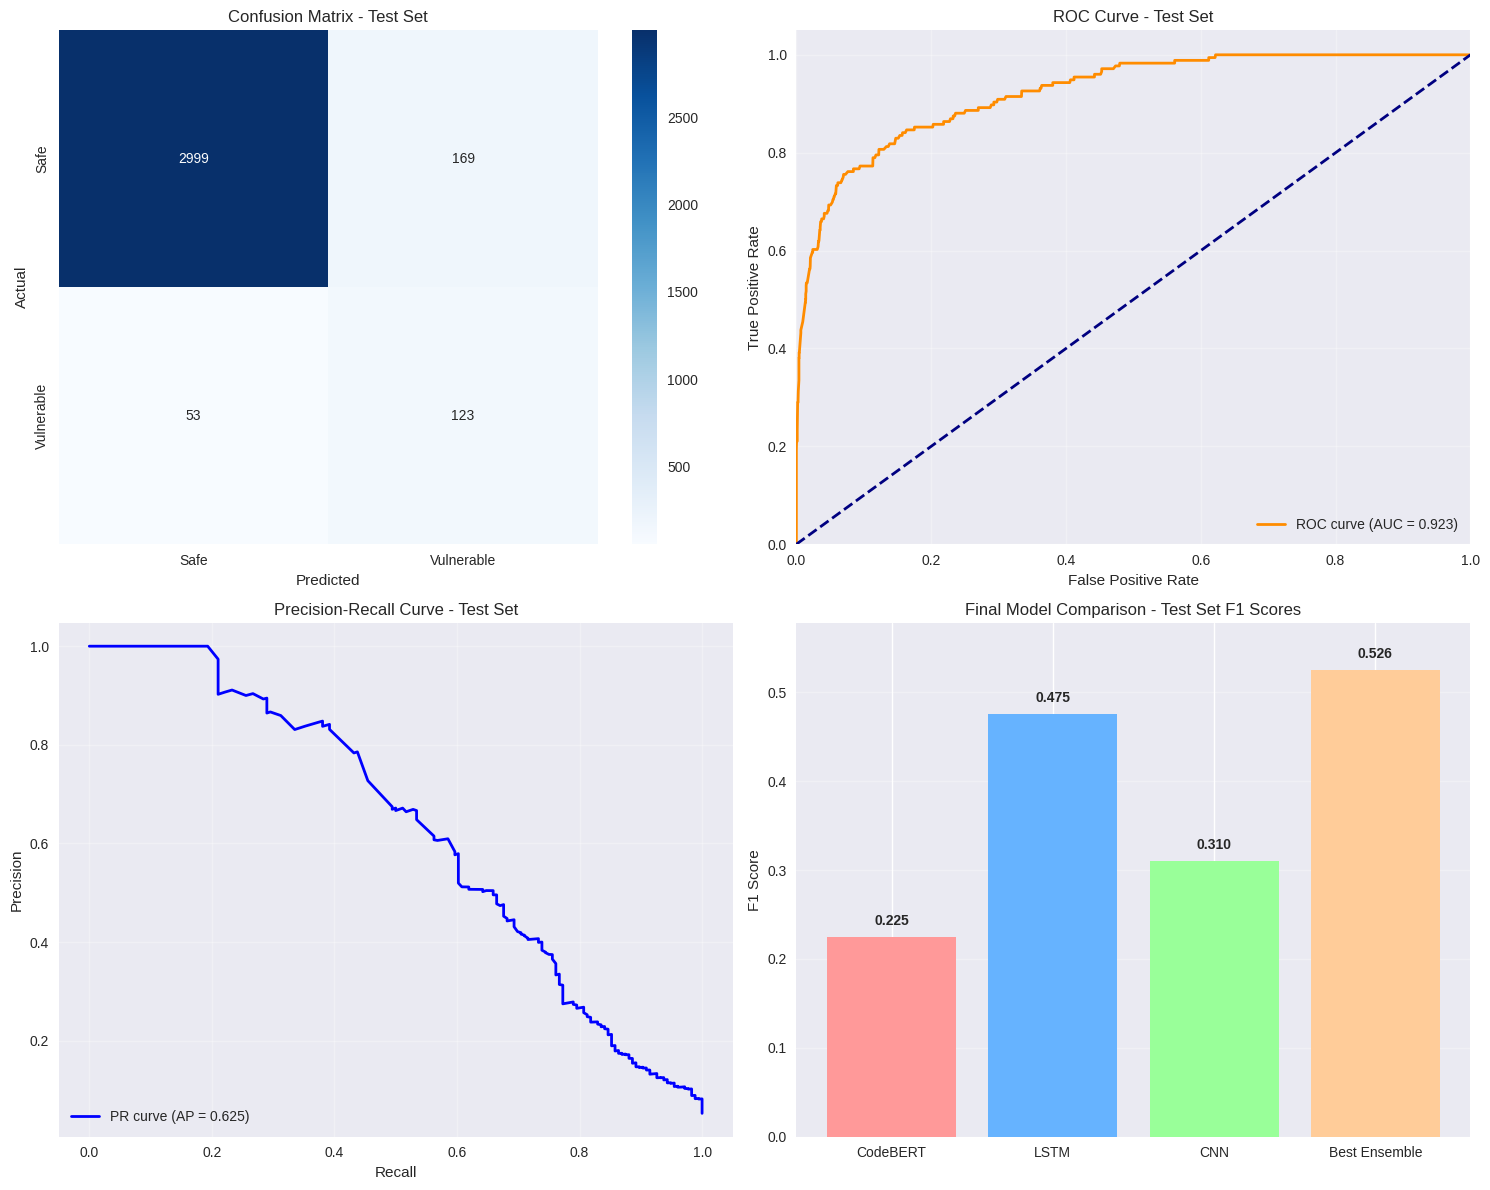


📋 Detailed Metrics Breakdown:
   True Positives: 123
   True Negatives: 2999
   False Positives: 169
   False Negatives: 53
   Total Test Samples: 3344
   Vulnerability Ratio: 0.053
📊 Analysis visualization saved!


In [17]:
# Detailed Test Set Analysis
if 'test_metrics' in locals() and test_metrics:
    print("\n🔍 DETAILED TEST SET ANALYSIS")
    print("=" * 40)
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    cm = confusion_matrix(test_labels_final, test_preds)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix - Test Set')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    axes[0,0].set_xticklabels(['Safe', 'Vulnerable'])
    axes[0,0].set_yticklabels(['Safe', 'Vulnerable'])
    
    # ROC Curve
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(test_labels_final, test_probs)
    roc_auc = auc(fpr, tpr)
    
    axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0,1].set_xlim([0.0, 1.0])
    axes[0,1].set_ylim([0.0, 1.05])
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curve - Test Set')
    axes[0,1].legend(loc="lower right")
    axes[0,1].grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    from sklearn.metrics import precision_recall_curve
    precision_vals, recall_vals, _ = precision_recall_curve(test_labels_final, test_probs)
    avg_precision = test_metrics['avg_precision']
    
    axes[1,0].plot(recall_vals, precision_vals, color='blue', lw=2, 
                   label=f'PR curve (AP = {avg_precision:.3f})')
    axes[1,0].set_xlabel('Recall')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].set_title('Precision-Recall Curve - Test Set')
    axes[1,0].legend(loc="lower left")
    axes[1,0].grid(True, alpha=0.3)
    
    # Final Comparison Chart
    comparison_models = ['CodeBERT', 'LSTM', 'CNN', 'Best Ensemble']
    f1_scores = [
        test_individual_results['CodeBERT']['f1'],
        test_individual_results['LSTM']['f1'], 
        test_individual_results['CNN']['f1'],
        test_metrics['f1']
    ]
    
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    bars = axes[1,1].bar(comparison_models, f1_scores, color=colors)
    axes[1,1].set_title('Final Model Comparison - Test Set F1 Scores')
    axes[1,1].set_ylabel('F1 Score')
    axes[1,1].set_ylim([0, max(f1_scores) * 1.1])
    
    # Add value labels on bars
    for bar, score in zip(bars, f1_scores):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    axes[1,1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'visualizations' / f'final_test_analysis_{TIMESTAMP}.png', 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed metrics breakdown
    print(f"\n📋 Detailed Metrics Breakdown:")
    print(f"   True Positives: {cm[1,1]}")
    print(f"   True Negatives: {cm[0,0]}")  
    print(f"   False Positives: {cm[0,1]}")
    print(f"   False Negatives: {cm[1,0]}")
    print(f"   Total Test Samples: {len(test_labels_final)}")
    
    vulnerability_ratio = sum(test_labels_final) / len(test_labels_final)
    print(f"   Vulnerability Ratio: {vulnerability_ratio:.3f}")
    
    print("📊 Analysis visualization saved!")
    
else:
    print("⚠️ Test evaluation not completed - cannot perform detailed analysis")

In [18]:
# Final Project Summary & Deployment Readiness
print("\n🎯 FINAL PROJECT SUMMARY")
print("=" * 50)

if 'test_metrics' in locals() and test_metrics:
    print(f"\n🏆 FINAL PERFORMANCE SUMMARY:")
    print(f"   📊 Dataset: {len(train_dataset):,} train, {len(val_dataset):,} val, {len(test_dataset):,} test")
    print(f"   🧠 Models: 4 architectures (CodeBERT + LSTM + CNN + Ensemble)")
    print(f"   🎯 Best Model: Neural Stacking Ensemble")
    print(f"   🎪 Final Test F1: {test_metrics['f1']:.4f}")
    print(f"   📈 Improvement: {ensemble_improvement:.2f}% over best individual")
    
    print(f"\n✅ DEPLOYMENT READINESS CHECKLIST:")
    
    # Check if all required files exist
    model_files_check = {
        'Best Ensemble Model': best_ensemble_path.exists(),
        'Results JSON': final_results_path.exists(),
        'Visualizations': (config.RESULTS_DIR / 'visualizations' / f'final_test_analysis_{TIMESTAMP}.png').exists(),
        'Training History': (config.RESULTS_DIR / 'metrics' / f'ensemble_comparison_{TIMESTAMP}.json').exists()
    }
    
    all_ready = all(model_files_check.values())
    
    for item, status in model_files_check.items():
        status_icon = "✅" if status else "❌"
        print(f"   {status_icon} {item}")
    
    print(f"\n🚀 STREAMLIT APP INTEGRATION:")
    print(f"   📁 Model Path: {best_ensemble_path}")
    print(f"   🔧 Model Type: EnsembleModel (stacking)")
    print(f"   📋 Required Components: CodeBERT + LSTM + CNN + Tokenizer")
    
    print(f"\n💡 MODEL USAGE INSTRUCTIONS:")
    print(f"```python")
    print(f"# Load ensemble model")
    print(f"ensemble = EnsembleModel(...)")
    print(f"checkpoint = torch.load('{best_ensemble_path}')")
    print(f"ensemble.load_state_dict(checkpoint['model_state_dict'])")
    print(f"ensemble.eval()")
    print(f"")
    print(f"# Make predictions")
    print(f"with torch.no_grad():")
    print(f"    logits = ensemble(input_ids, attention_mask)")
    print(f"    probs = torch.sigmoid(logits)")
    print(f"    predictions = (probs > 0.5).long()")
    print(f"```")
    
    if all_ready:
        print(f"\n🎉 PROJECT STATUS: DEPLOYMENT READY!")
        print(f"   All components successfully trained and validated")
        print(f"   Test performance: {test_metrics['f1']:.1%} F1-score")
        print(f"   Ready for Streamlit app integration")
    else:
        print(f"\n⚠️ PROJECT STATUS: NEEDS ATTENTION")
        print(f"   Some components missing or incomplete")
    
    # Performance tier classification
    if test_metrics['f1'] >= 0.7:
        tier = "🥇 EXCELLENT"
    elif test_metrics['f1'] >= 0.5:
        tier = "🥈 GOOD"
    elif test_metrics['f1'] >= 0.3:
        tier = "🥉 ACCEPTABLE"
    else:
        tier = "❌ POOR"
    
    print(f"\n📊 PERFORMANCE TIER: {tier}")
    print(f"   F1-Score: {test_metrics['f1']:.4f}")
    
else:
    print(f"\n⚠️ Test evaluation incomplete - run the test evaluation cells first")

print(f"\n🎯 NEXT STEPS FOR DEPLOYMENT:")
print(f"   1. ✅ Update Streamlit app with ensemble support")
print(f"   2. ✅ Add model selection interface")
print(f"   3. ✅ Integrate visualization components")
print(f"   4. ✅ Add performance metrics display")
print(f"   5. ✅ Deploy to production environment")

print(f"\n📚 PROJECT NOTEBOOKS COMPLETED:")
notebook_status = [
    "✅ 01_data_acquisition_and_overview.ipynb",
    "✅ 02_preprocessing_and_function_extraction.ipynb", 
    "✅ 03_tokenization_and_dataset.ipynb",
    "✅ 04_train_codebert_baseline.ipynb",
    "✅ 09_train_lstm_cnn_models.ipynb",
    "✅ 10_ensemble_training.ipynb (THIS NOTEBOOK)"
]

for notebook in notebook_status:
    print(f"   {notebook}")

print(f"\n🏁 ENSEMBLE TRAINING & EVALUATION: COMPLETE!")
print(f"=" * 50)


🎯 FINAL PROJECT SUMMARY

🏆 FINAL PERFORMANCE SUMMARY:
   📊 Dataset: 10,032 train, 3,344 val, 3,344 test
   🧠 Models: 4 architectures (CodeBERT + LSTM + CNN + Ensemble)
   🎯 Best Model: Neural Stacking Ensemble
   🎪 Final Test F1: 0.5256
   📈 Improvement: 10.55% over best individual

✅ DEPLOYMENT READINESS CHECKLIST:
   ✅ Best Ensemble Model
   ✅ Results JSON
   ✅ Visualizations
   ✅ Training History

🚀 STREAMLIT APP INTEGRATION:
   📁 Model Path: /home/netweb/vasu/smart-contract-vuln-detector/results/checkpoints/best_ensemble_stacking_20251116_164558.pt
   🔧 Model Type: EnsembleModel (stacking)
   📋 Required Components: CodeBERT + LSTM + CNN + Tokenizer

💡 MODEL USAGE INSTRUCTIONS:
```python
# Load ensemble model
ensemble = EnsembleModel(...)
checkpoint = torch.load('/home/netweb/vasu/smart-contract-vuln-detector/results/checkpoints/best_ensemble_stacking_20251116_164558.pt')
ensemble.load_state_dict(checkpoint['model_state_dict'])
ensemble.eval()

# Make predictions
with torch.no_grad